## Plots to compare the scoreing metrics 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import re


%load_ext autoreload
%autoreload 2
%matplotlib inline

### Combine all the model confidence scores and bin them 

In [ ]:
def melt_score_df(score_df, id_vars=['GO', 'Gene_Count']):
    columns_score = [col for col in score_df.columns if col.endswith('Score')]
    filtered_score_df = score_df[id_vars + columns_score]
    long_scores = filtered_score_df.melt(id_vars=id_vars, var_name='Score Type', value_name='Score')
    
    # Map the original score type names to the desired ones
    def map_score_type(score_type):
        if 'default' in score_type:
            return 'Real'
        elif '50perc_contaminated' in score_type:
            return '50/50 Mix'
        elif '100perc_contaminated' in score_type:
            return 'Random'
        else:
            return score_type
    
    # Apply the mapping
    long_scores['Score Type'] = long_scores['Score Type'].apply(map_score_type)
    
    # Remove unwanted symbols and return float
    long_scores.Score = long_scores.Score.apply(lambda x: float(re.sub("[^0-9.-]", "", x)) if isinstance(x, str) else x)
    
    return long_scores



In [ ]:
result_files = glob('./data/*_processed_toy_example.tsv')
print(len(result_files))
combine_df = pd.DataFrame()
for file in result_files:
    df = pd.read_csv(file, sep='\t')
    long_scores = melt_score_df(df)
    
    model_name = '_'.join(file.split('/')[-1].split('.')[0].split('_')[-2:])
    print(model_name)

    # map the model name to my own choice of names
    long_scores['Model'] = model_name
    combine_df = pd.concat([combine_df, long_scores])

new_model_name = {'mixtral_instruct': 'Mixtral Instruct', 'llama2_70b': 'Llama2 70b'}
combine_df['Model'] = combine_df['Model'].map(new_model_name)

# combine_df.to_csv('./data/combined_scores_df.tsv', sep='\t', index=False)

In [ ]:
combine_df.head()

## Plot the confidence score bins

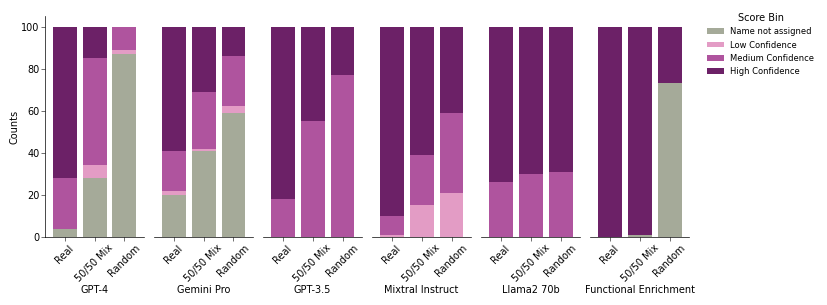

In [10]:
# Defining the custom order for Score Types and Models
score_type_order = ['Real', '50/50 Mix', 'Random']
model_order = ['Mixtral Instruct', 'Llama2 70b']
score_bin_order =[ 'Name not assigned', 'Low Confidence', 'Medium Confidence', 'High Confidence']
color_palette = ['#A5AA99','#e39cc5','#af549e', '#6c2167']

# Creating a categorical type for ordering
combine_df['Score Type'] = pd.Categorical(combine_df['Score Type'], categories=score_type_order, ordered=True)
combine_df['Model'] = pd.Categorical(combine_df['Model'], categories=model_order, ordered=True)
combine_df['Score Bin'] = pd.Categorical(combine_df['Score Bin'], categories=score_bin_order, ordered=True)

# Grouping and stacking data 
stacked_bins_data = combine_df.groupby(['Model', 'Score Type', 'Score Bin']).size().unstack().fillna(0)

# Modify the layout to include an additional subplot
fig, axes = plt.subplots(1, len(model_order) + 1, figsize=(7,3), sharey=True)

# Plotting for each model (existing code)
for i, model in enumerate(model_order):
    model_data = stacked_bins_data.loc[model]
    model_data.plot(kind='bar', stacked=True, ax=axes[i], width=0.8, legend=False, color=color_palette)
    axes[i].set_xlabel(model)
    axes[i].set_xticklabels(['Real', '50/50 Mix', 'Random'], rotation=45)
    if i == 0:
        axes[i].set_ylabel('Counts')
    else:
        axes[i].yaxis.set_visible(False)

# Adjusting the layout for the new plot
for i, ax in enumerate(axes):
    if i != 0:
        sns.despine(ax=ax, left=True)
    else:
        sns.despine(ax=ax)
        
plt.tight_layout()

handles, labels = axes[0].get_legend_handles_labels()

fig.legend(handles, labels, title='Score Bin', loc='upper left', bbox_to_anchor=(1, 1), fontsize=6)
plt.tight_layout(h_pad=0.01)
# Saving the figure
# plt.savefig('./figures/confidence_score_compare.svg', bbox_inches='tight')
plt.show()


### Calculate significance

In [1]:
import pandas as pd
data = pd.read_csv('./data/GO_term_analysis/model_compare/combined_scores_df.tsv', sep='\t')

In [3]:
data['Score Type'].unique()

array(['Real', '50/50 Mix', 'Random'], dtype=object)

In [4]:
import numpy as np
from scipy.stats import chi2_contingency


# Initialize a new results list to store the pairwise chi-square test results
pairwise_results = []

# Iterate over each model
for model in data['Model'].unique():
    model_data = data[data['Model'] == model]
    
    # Define the pairs for comparison
    comparison_pairs = [
        ('Real', '50/50 Mix'),  # Real vs contaminated
        ('Real', 'Random'),     # Real vs Random
        ('50/50 Mix', 'Random') # contaminated vs Random
    ]

    # Perform chi-square test for each pair
    for pair in comparison_pairs:
        # Creating a subset of data for the two score types being compared
        pair_data = model_data[model_data['Score Type'].isin(pair)]
        
        # Constructing the contingency table for 'Score Bin' across the selected 'Score Type'
        score_bin_table = pd.crosstab(pair_data['Score Bin'], pair_data['Score Type'])
        
        # If the table is valid, perform chi-square test, else skip
        if score_bin_table.shape[1] == 2:  # Ensure table is correct shape for comparison
            chi2, p, dof, expected = chi2_contingency(score_bin_table)
            pairwise_results.append({
                'Model': model,
                'Comparison': f"{pair[0]} vs {pair[1]}",
                'Chi-Square Statistic': chi2,
                'Chi-Square p-value': p
            })
        else:
            # Handle cases where the contingency table is not suitable for chi-square test
            pairwise_results.append({
                'Model': model,
                'Comparison': f"{pair[0]} vs {pair[1]}",
                'Chi-Square Statistic': np.nan,
                'Chi-Square p-value': np.nan
            })

# Convert the results to a DataFrame for better presentation
pairwise_results_df = pd.DataFrame(pairwise_results)
pairwise_results_df


,Model,Comparison,Chi-Square Statistic,Chi-Square p-value
0,GPT-4,Real vs 50/50 Mix,71.064828,2.524779e-15
1,GPT-4,Real vs Random,154.531868,2.773728e-33
2,GPT-4,50/50 Mix vs Random,73.076017,9.362626e-16
3,Gemini Pro,Real vs 50/50 Mix,17.665257,5.155977e-04
4,Gemini Pro,Real vs Random,47.774286,2.378503e-10
5,Gemini Pro,50/50 Mix vs Random,10.838693,1.263088e-02
6,Mixtral Instruct,Real vs 50/50 Mix,24.637718,4.466707e-06
7,Mixtral Instruct,Real vs Random,54.403679,1.536000e-12
8,Mixtral Instruct,50/50 Mix vs Random,8.082859,1.757234e-02
9,Llama2 70b,Real vs 50/50 Mix,0.223214,6.366016e-01
